In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [4]:
!unzip /content/drive/MyDrive/pixeled_annotations_train-20240414T060428Z-001.zip

Archive:  /content/drive/MyDrive/pixeled_annotations_train-20240414T060428Z-001.zip
  inflating: pixeled_annotations_train/seq_11_frame022.png  
  inflating: pixeled_annotations_train/seq_7_frame052.png  
  inflating: pixeled_annotations_train/seq_7_frame046.png  
  inflating: pixeled_annotations_train/seq_1_frame041.png  
  inflating: pixeled_annotations_train/seq_1_frame109.png  
  inflating: pixeled_annotations_train/seq_6_frame096.png  
  inflating: pixeled_annotations_train/seq_1_frame135.png  
  inflating: pixeled_annotations_train/seq_16_frame036.png  
  inflating: pixeled_annotations_train/seq_3_frame072.png  
  inflating: pixeled_annotations_train/seq_1_frame082.png  
  inflating: pixeled_annotations_train/seq_3_frame112.png  
  inflating: pixeled_annotations_train/seq_16_frame022.png  
  inflating: pixeled_annotations_train/seq_6_frame082.png  
  inflating: pixeled_annotations_train/seq_12_frame016.png  
  inflating: pixeled_annotations_train/seq_1_frame055.png  
  inflating:

In [4]:
! pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00


In [6]:
# import the necessary Library
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.models import Model,load_model
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import generic_utils
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [7]:
# Setting framework environment
os.environ["SM_FRAMEWORK"] = "tf.keras"
sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')

In [8]:
H = 480 # height of image # Height and widht of the image has been changed to 480 in the place of 256 that was originally given. when the original size of image 720 * 480 is rescalled to some lower value there is a some data loss. Therefore, smaller the value bigger will be the data losss, so i have increased the value of dimensions to 480*480 instead of 256*256 that was originally given to us with this assignment notebook.
W = 480 # width of image  #reason for heights and weights increase is given in above line.

'''This function is used to return the list of path for images and masks in
sorted order from the given directory respectively.'''
# function to return list of image paths and mask paths
def process_data(IMG_DIR, MASK_DIR):
    images = [os.path.join(IMG_DIR, x) for x in sorted(os.listdir(IMG_DIR))]
    masks = [os.path.join(MASK_DIR, x) for x in sorted(os.listdir(MASK_DIR))]

    return images, masks

'''This function is used to return splitted list of images and corresponding
mask paths in train and test by providing test size.'''
# function to load data and train test split
def load_data(IMG_DIR, MASK_DIR):
    X, y = process_data(IMG_DIR, MASK_DIR)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

'''This function is used to read images. It takes image path as input.
After reading image it is resized by width and height provide above(480 x 480).
Next normalization is done by dividing each values with 255. And the result is returned.'''
# function to read image
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

'''This function is used to read masks.'''
# function to read mask
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x

'''This function is used to generate tensorflow data pipeline.
The tensorflow data pipeline is mapped to function ‘preprocess’ .'''
# function for tensorflow dataset pipeline
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

'''This function takes image and mask path.
It reads the image and mask as provided by paths.
Mask is one hot encoded for multi class segmentation (here 4 class).'''
# function to read image and mask amd create one hot encoding for mask
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 4, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 4])

    return image, mask

In [11]:
RENDER_IMAGE_DIR_PATH = '/content/drive/MyDrive/COL828_Data_for_Assignment_3/train/images'
GROUND_MASK_DIR_PATH = '/content/drive/MyDrive/pixeled_annotations_train'

X_train, X_test, y_train, y_test = load_data(RENDER_IMAGE_DIR_PATH, GROUND_MASK_DIR_PATH)
print(f"Dataset:\n Train: {len(X_train)} \n Test: {len(X_test)}")

Dataset:
 Train: 1072 
 Test: 269


In [12]:
train_dataset = tf_dataset(X_train, y_train, batch= 8)
valid_dataset = tf_dataset(X_test, y_test, batch= 8)

In [13]:
#### Step 1: Creating a base model
IMG_SHAPE = (480, 480, 3)

# include_top specify that we don't want to use the top layer (classifier)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#### Step 2: Freezing the base

# It is important to freeze the convolutional base before you compile and train the model.
# Freezing prevents the weights in a given layer from being updated during training
# VGG19 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

#### Step 3: Adding the head

# inputs
inputs = tf.keras.Input(shape=(480, 480, 3))

# base with pretrained model
x = base_model(inputs, training=False)

# head layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2)(x)

# model
model = tf.keras.Model(inputs, outputs)

# Let's take a look at the final model architecture
model.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 480, 480, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 480, 480, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 240, 240, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 240, 240, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 240, 240, 128)     147584    
                                                              

In [30]:
BACKBONE = 'vgg16'
input_shape = (480, 480, 3)
n_classes = 4
activation = 'softmax'

# using segmentation_models to create U-net with vgg19 as a backbone
# and pretrained imagenet weights

# segmentation_model basically will create a mirror image of our backbone as expansion path and add to the contraction path
model = sm.Unet(backbone_name = BACKBONE,
                input_shape = input_shape,
                classes = n_classes,
                activation = activation,
                encoder_weights = 'imagenet')
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 480, 480, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 480, 480, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 480, 480, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 240, 240, 64)         0         ['block1_conv2[0][0]']        
                           

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping #importing the necessary modules for callbacks
from segmentation_models.metrics import iou_score
import datetime, os

""" Defining Hyperparameters """
img_shape = (480, 480, 3) #input shapes, default one with notebook (256,256,3) to presently this (480,480,3). This is done to accomadate the height and width increase in the input image that we have changed in the previous cells above.
num_classes = 4
lr = 1e-5 #decreased learning rate gives better generalization
batch_size = 16 #increasing the batch size can provide better performance
epochs = 30 #Increased epochs give better scores

""" Model building and compiling """
# metrics for result validation
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compiling the model
model.compile(loss = 'categorical_crossentropy',
               optimizer = tf.keras.optimizers.legacy.Adam(lr, epsilon=1e-8, decay=1e-6), #epsilon and decay are added as a way to increase the performance. epsilon is a very small number to prevent any division by zero in the implementation. decay helps us to increase performance by reducing the momentum of the optimizer. Adam uses Momentum and Adaptive Learning Rates to converge faster.
               metrics = metrics)

train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size


""" Callbacks """
#A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc). You can use callbacks to: Write TensorBoard logs after every batch of training to monitor your metrics, Periodically save your model to disk, Do early stopping, Get a view on internal states and statistics of a model during training.

current_datetime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath=f'/content/drive/MyDrive/models/VGG16.h5', monitor='val_iou_score', verbose=1, mode='max', save_best_only=True), # Create a callback that saves the model periodically as training moves along the number of epochs.

        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", mode='max', patience=4, factor=0.1, verbose=1, min_lr=1e-6), #This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.


        tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=5, verbose=1, mode='max'),  #Stop training when a monitored metric has stopped improving.
]

In [ ]:
model_history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=100,
        callbacks=callbacks
        )

Epoch 1/100
67/67 [==============================] - ETA: 0s - loss: 1.2183 - iou_score: 0.0051 - f1-score: 0.0099
Epoch 1: val_iou_score improved from -inf to 0.01125, saving model to /content/drive/MyDrive/models/VGG16.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 68s 971ms/step - loss: 1.2183 - iou_score: 0.0051 - f1-score: 0.0099 - val_loss: 1.4080 - val_iou_score: 0.0113 - val_f1-score: 0.0216 - lr: 1.0000e-05
Epoch 2/100
67/67 [==============================] - ETA: 0s - loss: 1.0573 - iou_score: 0.0055 - f1-score: 0.0108
Epoch 2: val_iou_score did not improve from 0.01125
67/67 [==============================] - 66s 987ms/step - loss: 1.0573 - iou_score: 0.0055 - f1-score: 0.0108 - val_loss: 1.2848 - val_iou_score: 0.0048 - val_f1-score: 0.0095 - lr: 1.0000e-05
Epoch 3/100
67/67 [==============================] - ETA: 0s - loss: 0.9362 - iou_score: 0.0112 - f1-score: 0.0214
Epoch 3: val_iou_score did not improve from 0.01125
67/67 [==============================] - 67s 1s/step - loss: 0.9362 - iou_score: 0.0112 - f1-score: 0.0214 - val_loss: 1.0464 - val_iou_score: 0.0047 - val_f1-score: 0.0092 - lr: 1.0000e-05
Epoch 4/100
67/67 [==============================] - ETA: 0s - loss: 0.8448 - iou_score: 0

In [20]:
loss = model_history.history["loss"]
# val_loss = results.history["val_loss"]

acc = model_history.history["iou_score"]
# val_acc = results.history["val_accuracy"]

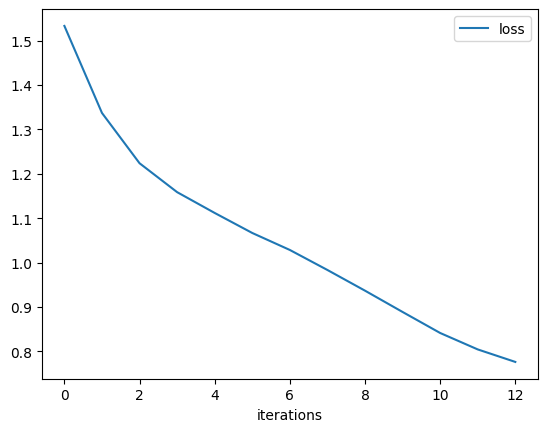

In [21]:
plt.plot(loss,label = "loss")
# plt.plot(val_loss,label  = "val loss")
plt.xlabel("iterations")
# plt.ylabel("X axis label")
plt.legend()

In [15]:
import tensorflow as tf

def iou_score(y_true, y_pred):
    inter = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)

    iou = inter.sum() / union.sum()
    return iou
def f1_score(y_true, y_pred):
  # Compute the F1 score using sklearn's f1_score function
  # You may need to adjust the parameters depending on your task
  return f1_score(y_true, y_pred)
# Define custom objects dictionary
custom_objects = {'BatchNormalization': tf.keras.layers.BatchNormalization}
# Register the custom metric function
tf.keras.utils.get_custom_objects()['iou_score'] = iou_score
tf.keras.utils.get_custom_objects()['f1-score'] = f1_score
# Load the model with custom objects
model = tf.keras.models.load_model('/content/drive/MyDrive/models/VGG16.h5', custom_objects=custom_objects)



In [9]:
from skimage.io import imread
from skimage.transform import resize

# function to predict result
def predict_image(img_path, mask_path, model):
    H = 480
    W = 480
    num_classes = 4

    img = imread(img_path)
    img = img[:480, :480, :]
    img = img / 255.0
    img = img.astype(np.float32)

    ## Read mask
    mask = imread(mask_path, as_gray = True)
    mask = mask[:480, :480]

    ## Prediction
    pred_mask = model.predict(np.expand_dims(img, axis=0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]


    # calculating IOU score
    inter = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)

    iou = inter.sum() / union.sum()

    return img, mask, pred_mask, iou

1/1 [==============================] - 5s 5s/step


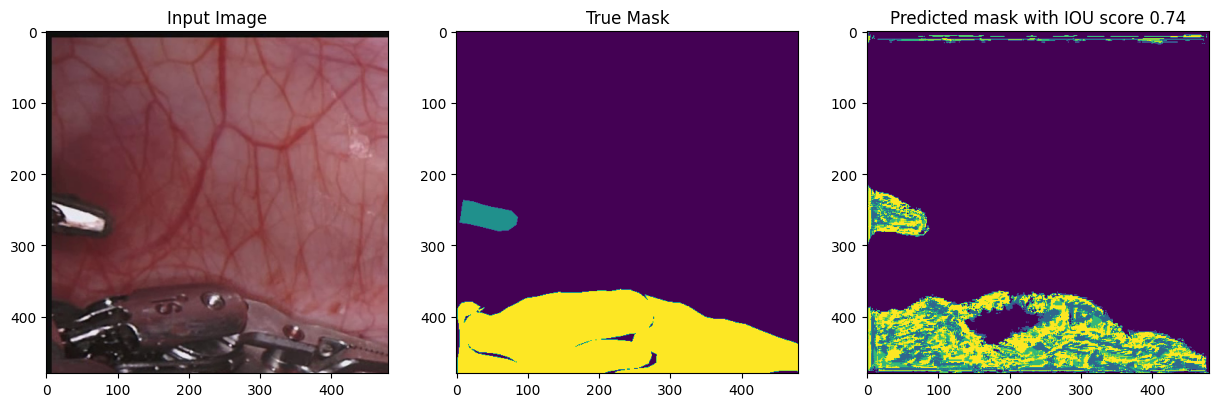

In [16]:
img_path = '/content/drive/MyDrive/COL828_Data_for_Assignment_3/train/images/seq_1_frame015.png'
mask_path = '/content/drive/MyDrive/COL828_Data_for_Assignment_3/train/annotations/seq_1_frame015.png'

img, mask, pred_mask, iou = predict_image(img_path, mask_path, model)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("True Mask")
ax2.imshow(mask)

ax3.set_title("Predicted mask with IOU score %.2f"%(iou))
ax3.imshow(pred_mask)

plt.show()